In [51]:
#Import necessary library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from itertools import product
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping
import os

In [52]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [53]:
!ls

Checkpoint_count.xlsx  loss_plot.png  sample_data  weather.xlsx


In [54]:
#Read the data into dataframe
df_weather = pd.read_excel('weather.xlsx',skiprows=2)
df_checkpoint = pd.read_excel('Checkpoint_count.xlsx',skiprows=0)
df_weather = df_weather.rename(columns={'Date/Time':'Date'})



In [55]:
#Display first 5 data of weather data set
df_weather.head(5)

,Date,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,2015-01-01,2015,1,1,‡,-3.0,NaN,-7.6,NaN,-5.3,...,1.8,NaN,1.8,NaN,0.0,NaN,22.0,NaN,63,NaN
1,2015-01-02,2015,1,2,‡,-3.4,NaN,-14.2,NaN,-8.8,...,0.0,T,0.0,T,1.0,NaN,27.0,NaN,50,NaN
2,2015-01-03,2015,1,3,‡,-8.5,NaN,-17.7,NaN,-13.1,...,17.0,NaN,17.0,NaN,1.0,NaN,3.0,NaN,41,NaN
3,2015-01-04,2015,1,4,‡,3.0,NaN,-8.6,NaN,-2.8,...,0.4,NaN,27.2,NaN,8.0,NaN,26.0,NaN,69,NaN
4,2015-01-05,2015,1,5,‡,-5.3,NaN,-17.9,NaN,-11.6,...,0.0,T,0.0,T,6.0,NaN,27.0,NaN,74,NaN


In [56]:
#Display first 5 data of checkpoint data set
df_checkpoint.head(5)

,Date,Time,check_point0,check_point1,check_point2,check_point3,check_point4,check_point5,check_point6,check_point7,...,check_point11,check_point12,check_point13,check_point14,check_point15,check_point16,check_point17,check_point18,check_point19,check_point20
0,2015-01-01 00:00:00,00:00:00,58,12,4,17,33.0,49,21,16,...,NaN,58,91,24,3,NaN,17,78,21,6
1,2015-02-01 00:00:00,00:00:00,75,7,5,15,30.0,113,27,9,...,NaN,109,177,32,13,NaN,11,57,77,4
2,2015-03-01 00:00:00,00:00:00,79,7,3,7,30.0,107,36,12,...,NaN,71,131,33,5,NaN,14,174,40,5
3,2015-04-01 00:00:00,00:00:00,10,1,21,0,10.0,35,29,1,...,NaN,6,11,6,1,NaN,1,20,6,0
4,2015-05-01 00:00:00,00:00:00,42,0,2,0,27.0,90,21,1,...,NaN,0,5,49,20,NaN,0,41,56,10


In [57]:
#Display unique times of Time feature
df_checkpoint['Time'].unique()


array([datetime.time(0, 0)], dtype=object)

In [58]:
#There is only one unique value for this Time feature,So it will contribute much to predict our target variable. Hence removing it.
df_checkpoint=df_checkpoint.drop(columns='Time')


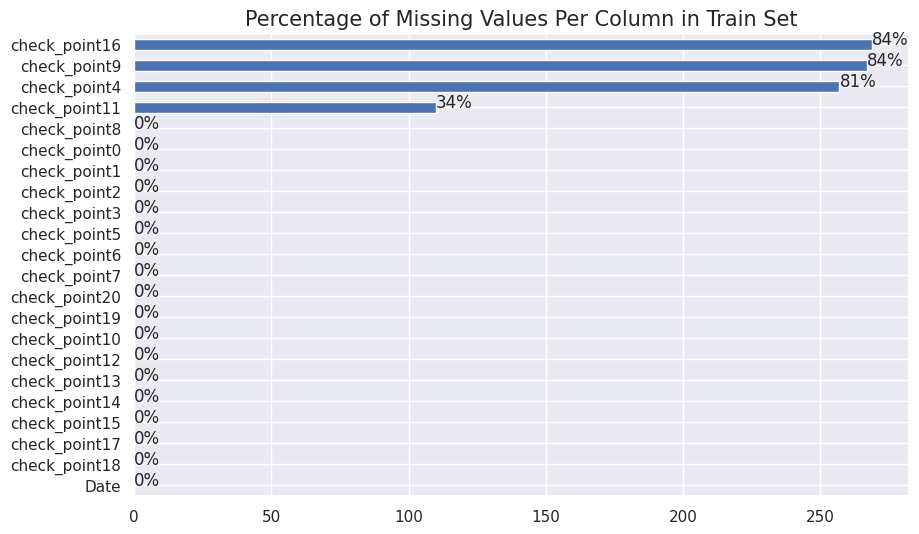

In [59]:
# Check if there any missing values in any checkpoint
ax = df_checkpoint.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 6))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/df_checkpoint.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

In [60]:
#For checkpoint 16,9 and 4 more than 80% data (i.e no of rented cycle from that checkpoint) is missing. So I will remove those checkpoints and will not cosider for predicting no of cycle rented on a day.
df_checkpoint = df_checkpoint.drop(columns=['check_point16','check_point9','check_point4'])

In [61]:
#For checkpoint11 34% data is missing
#I will impute the missing data of checkpoint11
#To impute missing data of checkpoint, i am adding a new feature 'week' , which defines what is the day of the week (0=Monday,1=Tuesday...6=Sunday)
# I am calculating mean no of cycles rented from checkpoint11 for a particular day. Will fill the missing data with this mean values corresponding to a particular day
from datetime import datetime
def get_wk(x):
  return (datetime.date(x).weekday())
df_checkpoint['Date'] = pd.to_datetime(df_checkpoint['Date'])
df_checkpoint['week'] = df_checkpoint['Date'].apply(get_wk)
average_by_day = dict(df_checkpoint.groupby('week')['check_point11'].mean())
df_checkpoint['check_point11'].fillna(df_checkpoint['week'].map(average_by_day),inplace=True)


<ipython-input-61-6e2f8d8c1e92>:8: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_checkpoint['Date'] = pd.to_datetime(df_checkpoint['Date'])


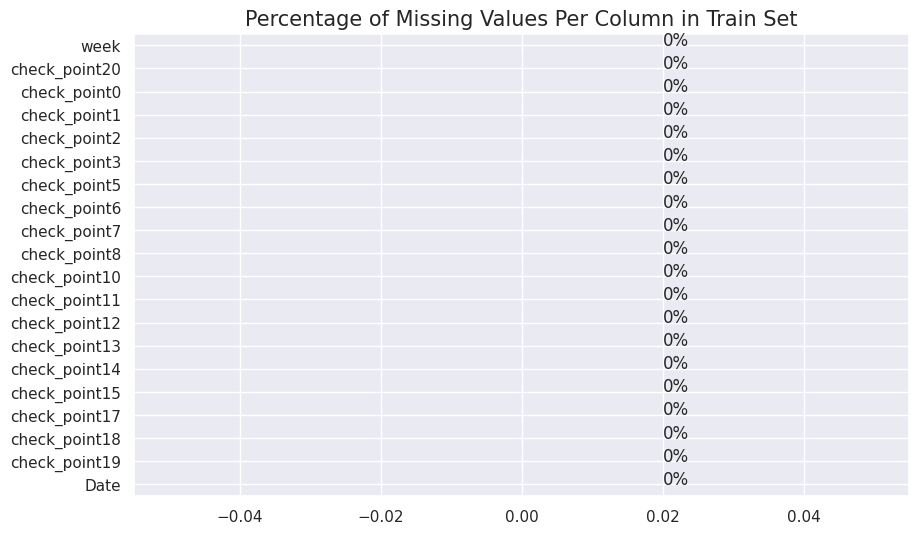

In [62]:
# Check if there any missing values in any checkpoint after data imputation
ax = df_checkpoint.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 6))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/df_checkpoint.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))


In [63]:
#Calculation to cycle rented for a particular date by adding the all checkpoints data for that date
df_checkpoint['Total_rented_cycle']= df_checkpoint.iloc[:,1:].sum(axis=1)

In [64]:
df_checkpoint.head(5)

,Date,check_point0,check_point1,check_point2,check_point3,check_point5,check_point6,check_point7,check_point8,check_point10,...,check_point12,check_point13,check_point14,check_point15,check_point17,check_point18,check_point19,check_point20,week,Total_rented_cycle
0,2015-01-01,58,12,4,17,49,21,16,16,7,...,58,91,24,3,17,78,21,6,3,2801.566667
1,2015-02-01,75,7,5,15,113,27,9,32,11,...,109,177,32,13,11,57,77,4,6,2806.166667
2,2015-03-01,79,7,3,7,107,36,12,18,2,...,71,131,33,5,14,174,40,5,6,2776.166667
3,2015-04-01,10,1,21,0,35,29,1,0,0,...,6,11,6,1,1,20,6,0,2,2358.300000
4,2015-05-01,42,0,2,0,90,21,1,1,6,...,0,5,49,20,0,41,56,10,4,2534.600000


In [65]:
#Merging the two data frame into a single data frame for ease of calculation
print("Total no of rows in df_weather and df_checkpoint before merge",len(df_weather),len(df_checkpoint))
df = pd.merge(df_weather,df_checkpoint,on='Date',how='inner')
print("Total no of rows in after merge",len(df))

Total no of rows in df_weather and df_checkpoint before merge 365 319
Total no of rows in after merge 319


In [66]:
#Data frame feature information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319 entries, 0 to 318
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       319 non-null    datetime64[ns]
 1   Year                       319 non-null    int64         
 2   Month                      319 non-null    int64         
 3   Day                        319 non-null    int64         
 4   Data Quality               319 non-null    object        
 5   Max Temp (°C)              319 non-null    float64       
 6   Max Temp Flag              0 non-null      float64       
 7   Min Temp (°C)              319 non-null    float64       
 8   Min Temp Flag              1 non-null      object        
 9   Mean Temp (°C)             319 non-null    float64       
 10  Mean Temp Flag             1 non-null      object        
 11  Heat Deg Days (°C)         319 non-null    float64       
 12  Heat Deg

In [67]:
#Statistical Description of data frame
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,319.0,2015.000000,0.000000,2015.000000,2015.00000,2015.0,2015.00,2015.0
Month,319.0,5.990596,3.189493,1.000000,3.00000,6.0,9.00,12.0
Day,319.0,15.144201,8.968037,1.000000,7.00000,15.0,23.00,31.0
Max Temp (°C),319.0,12.712226,13.420805,-18.000000,2.60000,15.3,24.40,32.2
Max Temp Flag,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Min Temp (°C),319.0,2.744828,13.174848,-27.500000,-6.00000,5.2,14.05,21.9
Mean Temp (°C),319.0,7.739498,13.207652,-20.900000,-1.75000,10.2,19.30,27.1
Heat Deg Days (°C),319.0,11.286834,12.140367,0.000000,0.00000,7.8,19.75,38.9
Cool Deg Days (°C),319.0,1.026332,1.952598,0.000000,0.00000,0.0,1.30,9.1
Total Rain (mm),307.0,2.432573,6.438770,0.000000,0.00000,0.0,1.00,47.2


In [68]:
#First 5 data point of merged data frame
df.head(5)

,Date,Year,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,Min Temp (°C),Min Temp Flag,Mean Temp (°C),...,check_point12,check_point13,check_point14,check_point15,check_point17,check_point18,check_point19,check_point20,week,Total_rented_cycle
0,2015-01-01,2015,1,1,‡,-3.0,NaN,-7.6,NaN,-5.3,...,58,91,24,3,17,78,21,6,3,2801.566667
1,2015-01-02,2015,1,2,‡,-3.4,NaN,-14.2,NaN,-8.8,...,49,127,17,5,6,124,27,3,4,2724.600000
2,2015-01-03,2015,1,3,‡,-8.5,NaN,-17.7,NaN,-13.1,...,56,144,27,8,6,151,53,9,5,2639.866667
3,2015-01-04,2015,1,4,‡,3.0,NaN,-8.6,NaN,-2.8,...,763,1197,343,33,568,853,834,100,6,10849.166667
4,2015-01-05,2015,1,5,‡,-5.3,NaN,-17.9,NaN,-11.6,...,3634,4643,2334,0,2536,3964,3249,465,0,51178.000000


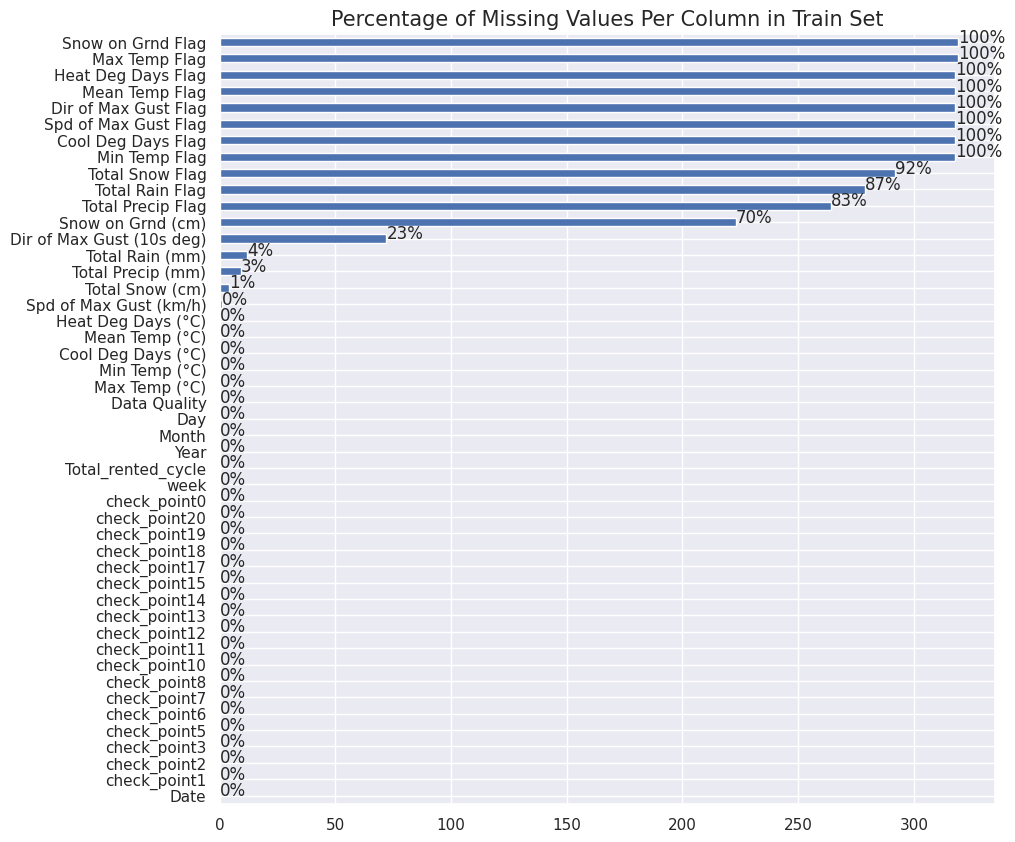

In [69]:
# Check if there any missing values in the merged dataset
ax = df.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/df.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Unique values per columns:  {'Date': 319, 'Year': 1, 'Month': 12, 'Day': 30, 'Data Quality': 1, 'Max Temp (°C)': 219, 'Max Temp Flag': 1, 'Min Temp (°C)': 227, 'Min Temp Flag': 2, 'Mean Temp (°C)': 215, 'Mean Temp Flag': 2, 'Heat Deg Days (°C)': 164, 'Heat Deg Days Flag': 2, 'Cool Deg Days (°C)': 52, 'Cool Deg Days Flag': 2, 'Total Rain (mm)': 55, 'Total Rain Flag': 3, 'Total Snow (cm)': 28, 'Total Snow Flag': 3, 'Total Precip (mm)': 62, 'Total Precip Flag': 3, 'Snow on Grnd (cm)': 21, 'Snow on Grnd Flag': 1, 'Dir of Max Gust (10s deg)': 35, 'Dir of Max Gust Flag': 2, 'Spd of Max Gust (km/h)': 28, 'Spd of Max Gust Flag': 2, 'check_point0': 307, 'check_point1': 231, 'check_point2': 260, 'check_point3': 254, 'check_point5': 292, 'check_point6': 273, 'check_point7': 254, 'check_point8': 264, 'check_point10': 227, 'check_point11': 208, 'check_point12': 298, 'check_point13': 306, 'check_point14': 294, 'check_point15': 209, 'check_point17': 274, 'check_point18': 302, 'check_point19': 302, 'c

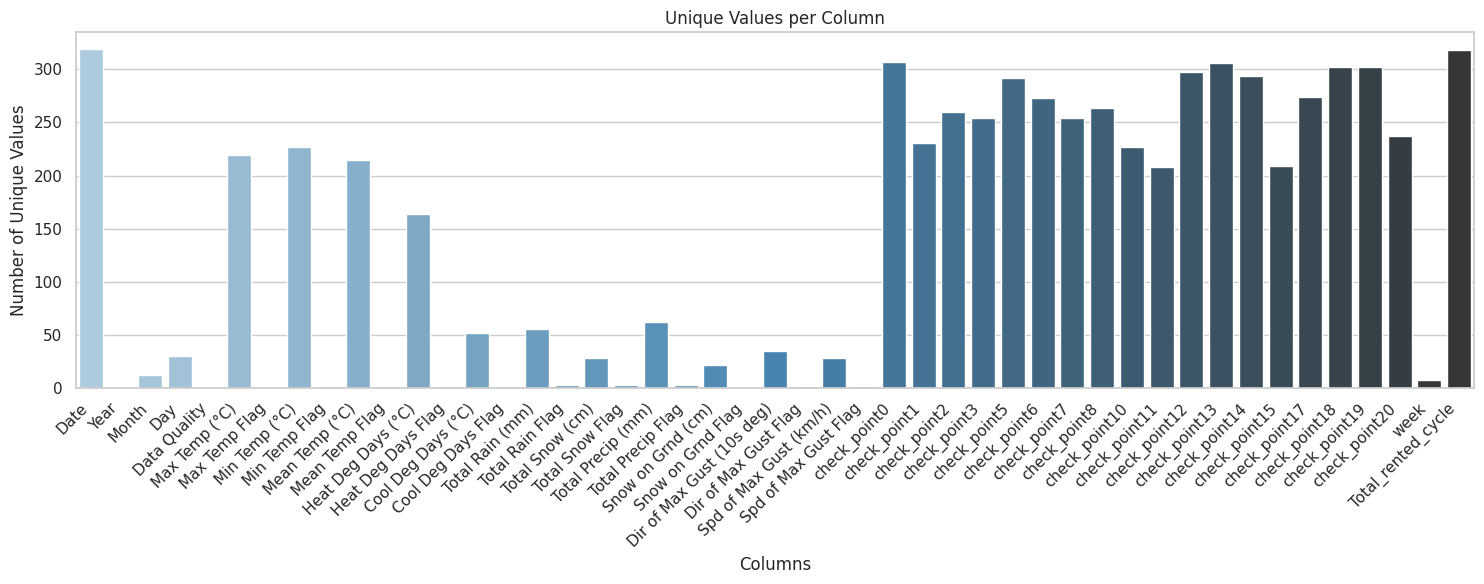

In [70]:

def fraction_unique(x):
    return len(df[x].unique())
number_unique_vals = {x : fraction_unique(x) for x in df.columns}
print("Unique values per columns: ",number_unique_vals)
unique_vals_df = pd.DataFrame.from_dict(number_unique_vals, orient='index', columns=['Number of Unique Values'])

# Plotting the result as a count plot
plt.figure(figsize=(15, 6))
sns.set(style="whitegrid")
ax = sns.barplot(x=unique_vals_df.index, y=unique_vals_df['Number of Unique Values'], palette="Blues_d")
ax.set(xlabel="Columns", ylabel="Number of Unique Values", title="Unique Values per Column")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [71]:
#Removing weather features having more than 70% missing data
#Removing features having only one unique value
cols_exclude=['Year','Data Quality','Max Temp Flag','Snow on Grnd Flag','Dir of Max Gust Flag',
              'Spd of Max Gust Flag','Cool Deg Days Flag','Min Temp Flag','Mean Temp Flag',
              'Heat Deg Days Flag','Snow on Grnd (cm)','Total Snow Flag','Total Rain Flag','Total Precip Flag',
              ]
df = df.drop(columns = cols_exclude)

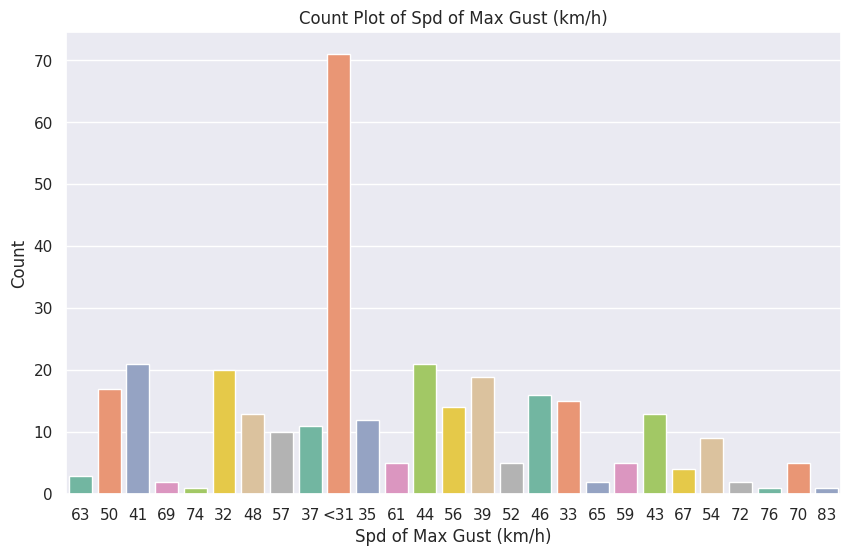

In [72]:
#count plot of 'Spd of Max Gust (km/h)'
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.countplot(x='Spd of Max Gust (km/h)', data=df, palette='Set2')
plt.xlabel('Spd of Max Gust (km/h)')
plt.ylabel('Count')
plt.title('Count Plot of Spd of Max Gust (km/h)')
plt.show()


In [73]:
#Replacing all the values '<31' of 'Spd of Max Gust (km/h)' with 30 and converting it to numerical feature
df['Spd of Max Gust (km/h)'] = df['Spd of Max Gust (km/h)'].replace({'<31':30})
df['Spd of Max Gust (km/h)'] = df['Spd of Max Gust (km/h)'].astype(float)

<ipython-input-74-1e7ad6e34c80>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


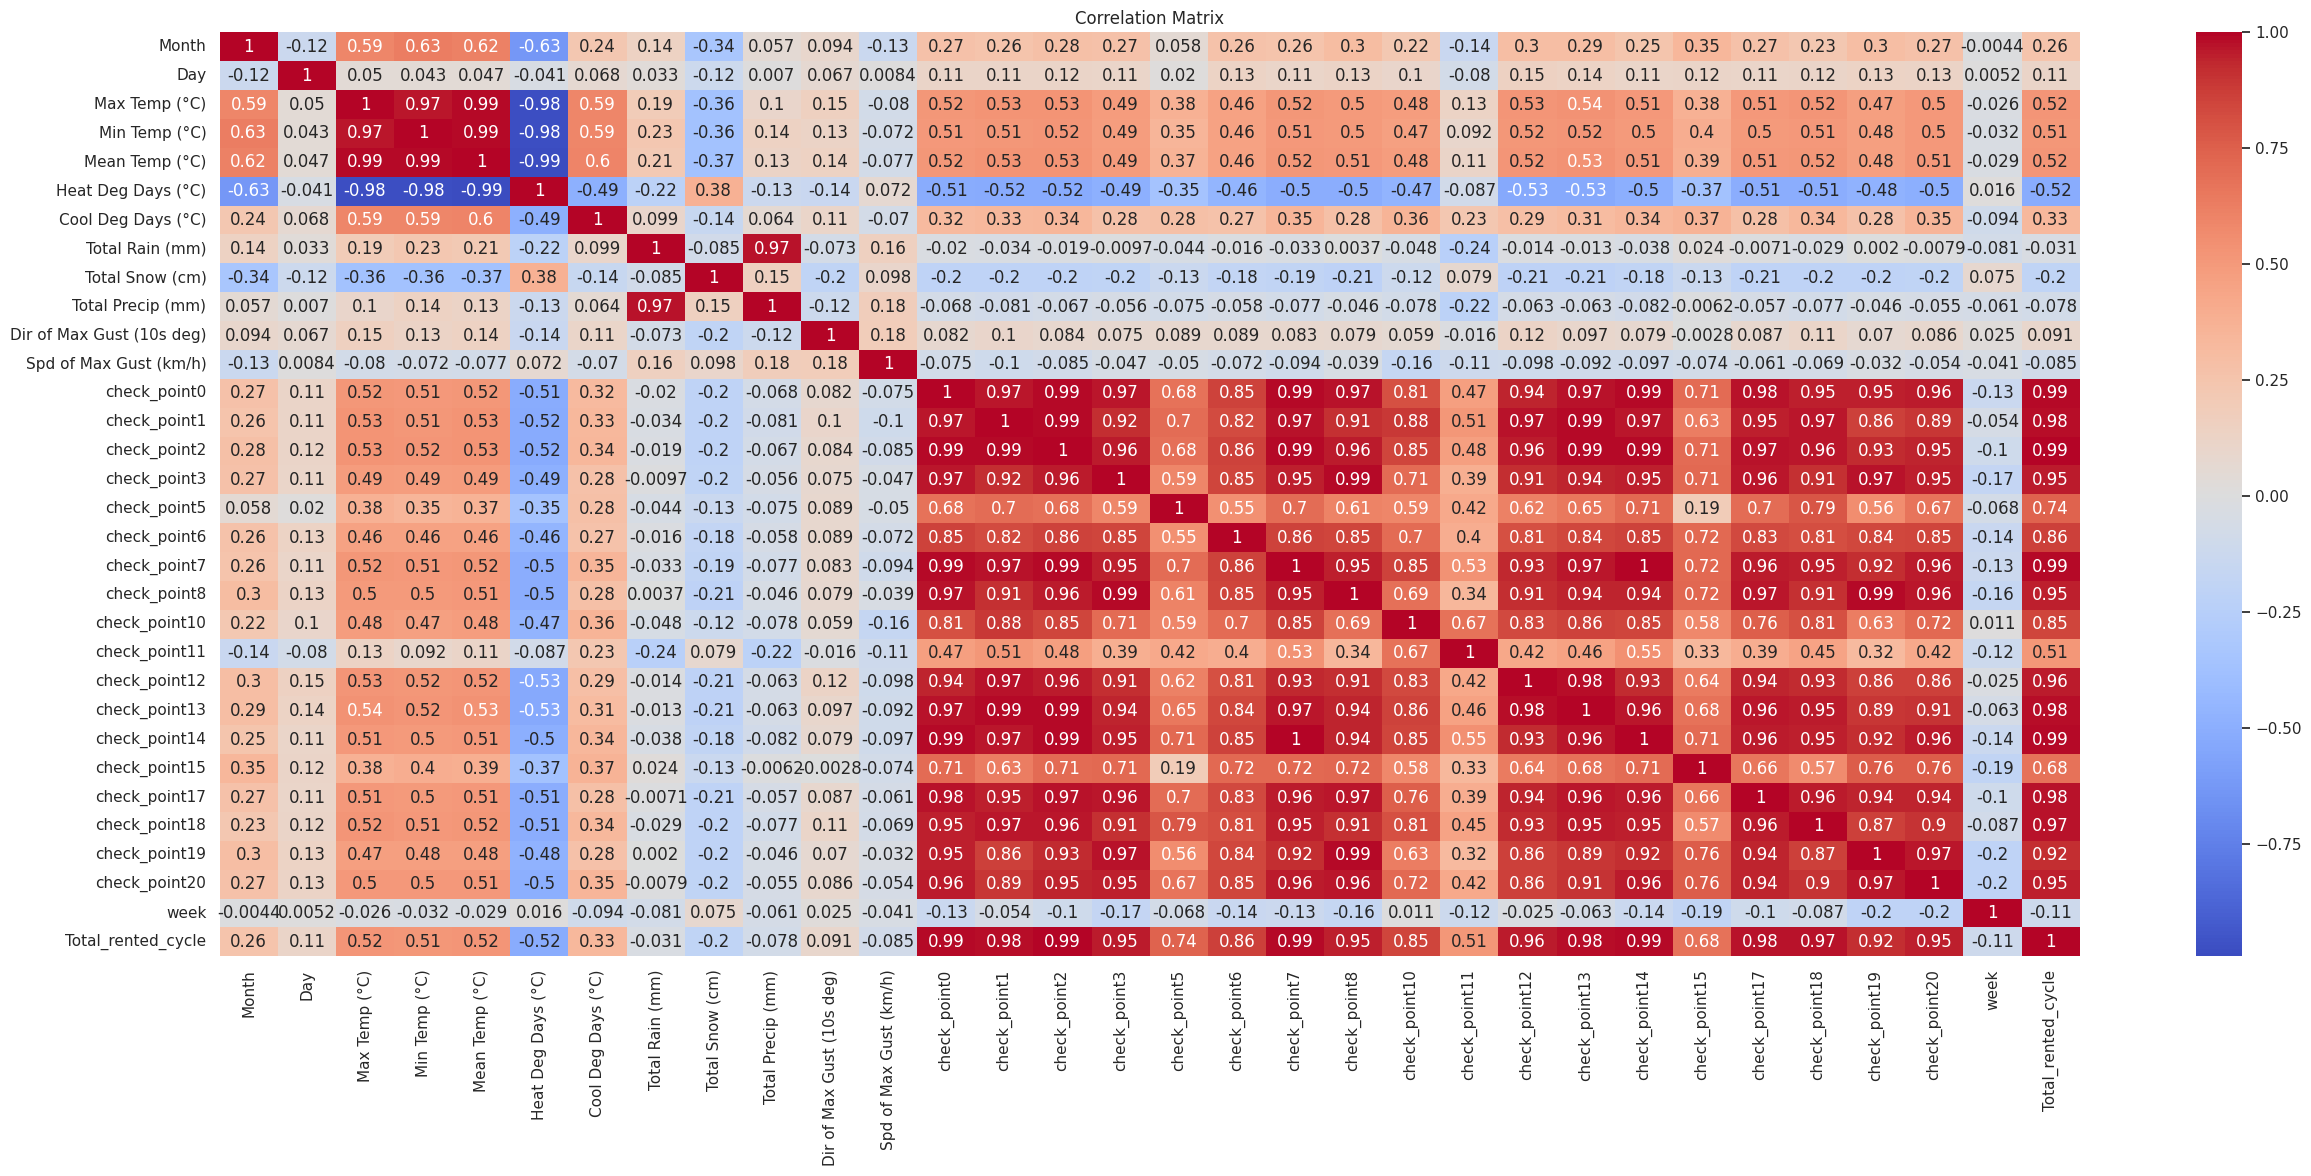

In [74]:
#Correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = df.corr()
plt.figure(figsize=(30, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [75]:
#From correlation matrix we see that 'Total Rain (mm)','Total Precip (mm)', 'Dir of Max Gust (10s deg)','Spd of Max Gust (km/h)' are not much correlated to 'Total_rented_cycle'.
#Hence removing those features also
df = df.drop(columns = ['Total Rain (mm)','Total Precip (mm)', 'Dir of Max Gust (10s deg)','Spd of Max Gust (km/h)'])

In [76]:
df.columns

Index(['Date', 'Month', 'Day', 'Max Temp (°C)', 'Min Temp (°C)',
       'Mean Temp (°C)', 'Heat Deg Days (°C)', 'Cool Deg Days (°C)',
       'Total Snow (cm)', 'check_point0', 'check_point1', 'check_point2',
       'check_point3', 'check_point5', 'check_point6', 'check_point7',
       'check_point8', 'check_point10', 'check_point11', 'check_point12',
       'check_point13', 'check_point14', 'check_point15', 'check_point17',
       'check_point18', 'check_point19', 'check_point20', 'week',
       'Total_rented_cycle'],
      dtype='object')

In [77]:
#To impute the missing data of 'Total Snow (cm)', i will take the mean value of 'Total Snow (cm)' for that particular month.
average_snow_by_month = dict(df.groupby('Month')['Total Snow (cm)'].mean())
df['Total Snow (cm)'].fillna(df['Month'].map(average_snow_by_month),inplace=True)

In [78]:
df.head(5)

,Date,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C),Total Snow (cm),check_point0,...,check_point12,check_point13,check_point14,check_point15,check_point17,check_point18,check_point19,check_point20,week,Total_rented_cycle
0,2015-01-01,1,1,-3.0,-7.6,-5.3,23.3,0.0,1.8,58,...,58,91,24,3,17,78,21,6,3,2801.566667
1,2015-01-02,1,2,-3.4,-14.2,-8.8,26.8,0.0,0.0,54,...,49,127,17,5,6,124,27,3,4,2724.600000
2,2015-01-03,1,3,-8.5,-17.7,-13.1,31.1,0.0,17.0,96,...,56,144,27,8,6,151,53,9,5,2639.866667
3,2015-01-04,1,4,3.0,-8.6,-2.8,20.8,0.0,0.4,989,...,763,1197,343,33,568,853,834,100,6,10849.166667
4,2015-01-05,1,5,-5.3,-17.9,-11.6,29.6,0.0,0.0,4762,...,3634,4643,2334,0,2536,3964,3249,465,0,51178.000000


In [79]:
#Sort the dataframe by date
df = df.sort_values(by='Date')

In [80]:
#Minimum date in df
min(df['Date'])

Timestamp('2015-01-01 00:00:00')

In [81]:
#Maximum date in df
max(df['Date'])

Timestamp('2015-12-11 00:00:00')

In [82]:
#Function to calculate MAPE
def cal_mape(y_true,y_pred):
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  return mape


In [83]:
df.columns

Index(['Date', 'Month', 'Day', 'Max Temp (°C)', 'Min Temp (°C)',
       'Mean Temp (°C)', 'Heat Deg Days (°C)', 'Cool Deg Days (°C)',
       'Total Snow (cm)', 'check_point0', 'check_point1', 'check_point2',
       'check_point3', 'check_point5', 'check_point6', 'check_point7',
       'check_point8', 'check_point10', 'check_point11', 'check_point12',
       'check_point13', 'check_point14', 'check_point15', 'check_point17',
       'check_point18', 'check_point19', 'check_point20', 'week',
       'Total_rented_cycle'],
      dtype='object')

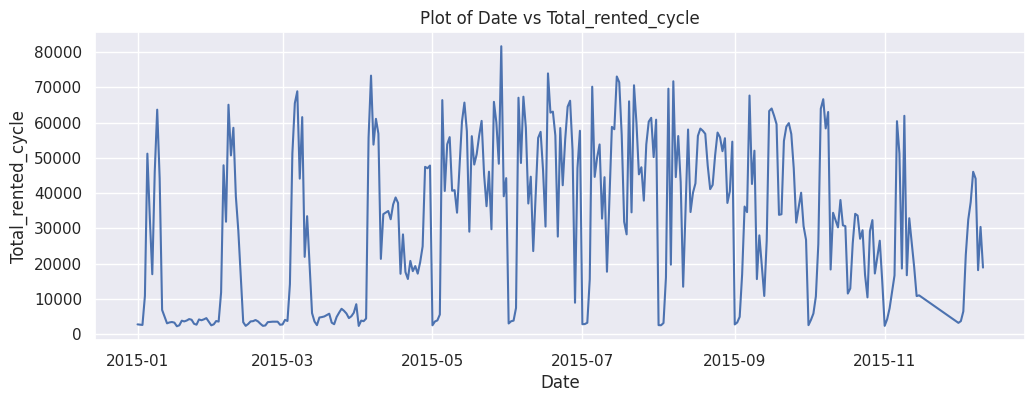

In [84]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 4))
plt.xlabel('Date')
plt.ylabel('Total_rented_cycle')
plt.title('Plot of Date vs Total_rented_cycle')
plt.plot(df['Date'],df['Total_rented_cycle'])
plt.show()

From the given problem set description it seems that weather data is additional data set, where as weather information is given as additional. The target variable 'sum of number of cycles that have been rented on that particular date' i have calculation by taking the summation of all the cycles rented from any checkpoint on that particular day.
I think we should consider the weather information also to predict the target, because weather information higly influences one's decision to take a cycle on rent. For example if the weather is too hot, then one might not want ride a cycle.
I have developed two model to predict out target. One is classical Linear Regression Model and another is LSTM based deep learning Model. As in the problem set it is specifically mentioned to implement some deep learning method, So I have not explored other classical ML model / Statistical Model.
Linear Regression is providing quite good MAPE.


In [85]:
def predict_cycle_rent(df):
  y=df['Total_rented_cycle']
  X = df.drop(columns=['Date','Total_rented_cycle'])
  X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  scaler = StandardScaler()
  scaler.fit(X_train_df)
  X_train = scaler.transform(X_train_df)
  X_test = scaler.transform(X_test_df)

  reg = LinearRegression()
  reg.fit(X_train, y_train)
  y_pred = reg.predict(X_test)
  mse = mean_squared_error(y_test, y_pred)
  print("Mean Squared Error:", mse)
  mape = cal_mape(y_test,y_pred)
  print("MAPE: ",mape)



In [86]:
df = df[['Date', 'Month', 'Day', 'week', 'Max Temp (°C)', 'Min Temp (°C)',
       'Mean Temp (°C)', 'Heat Deg Days (°C)', 'Cool Deg Days (°C)',
       'Total Snow (cm)', 'check_point0',
       'check_point1', 'check_point2', 'check_point3',
       'check_point5', 'check_point6', 'check_point7', 'check_point8',
      'check_point10', 'check_point11', 'check_point12',
       'check_point13', 'check_point14', 'check_point15',
       'check_point17', 'check_point18', 'check_point19', 'check_point20',
       'Total_rented_cycle']]



In [87]:
predict_cycle_rent(df)

Mean Squared Error: 7.901190437015307e-23
MAPE:  7.386449031486443e-14


In order to handle the timeseries nature of the the dataset, I am forming the fixed size batch of historic data and predicting the next one output(i.e target variable)
I have two LSTM based model. The first model considers checkpoints as input features along with weather data. Where as second model predicts total rented cycles for a
particular date based only the weather data (not considering checkpoints data as input feature as we are calculating the target variable by taking sum of checkpoints value).

##Model-1

In [88]:
#Forming the Input and Target dataset
y=df['Total_rented_cycle']
X = df.drop(columns=['Date','Total_rented_cycle'])
WINDOW_LENGTH_set = [7]
dropout_set = [0.04]
combination = list(product(WINDOW_LENGTH_set,dropout_set))

accuracy=[]
print("WINDOW_LENGTH_set,dropout_set,train_loss,val_loss,mape")
for comb in combination:
  window_size, dropout= comb[0],comb[1]
  print(window_size, dropout,"- - -")
  #Forming the batched data
  X_b, y_b = [], []
  for i in range(window_size-1, len(X)):
    dfx = X[i-window_size+1:i+1]
    dfy = y[i]
    X_b.append(X[i-window_size+1:i+1])
    y_b.append(y[i])
  X_b = np.array(X_b)
  y_b = np.array(y_b)
  #Spliting into train and test data set
  X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

  #Creating tensorflow training and validation Dataset object
  train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  train_data = train_data.cache().shuffle(100).batch(16).repeat()
  val_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
  val_data = val_data.batch(32).repeat()

  #Defining LSTM Model Architechture
  # dropout = 0.02
  lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(
            64, input_shape=X_train.shape[-2:], dropout=dropout),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dense(64),
        tf.keras.layers.Dense(1)
    ])
  #Early stopping criteria
  early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
  #Building the Model
  mape = tf.keras.losses.MeanAbsolutePercentageError()
  lstm_model.compile(optimizer='adam', loss=mape)

  # Training the model with early stopping callback
  model_history = lstm_model.fit(
      train_data,
      epochs=200,
      steps_per_epoch=500,
      validation_data=val_data,
      validation_steps=50,
      callbacks=[early_stopping]
  )
  #Predicting with trained Model
  yhat = lstm_model.predict(X_test).reshape(1, -1)[0]

  best_train_loss = min(model_history.history['loss'])
  best_val_loss = min(model_history.history['val_loss'])
  MAPE=cal_mape(y_test,yhat)

  print(f"Best training loss:{best_train_loss}, Best Validation loss:{best_val_loss}, MAPE on test set:{MAPE}")
  accuracy.append([window_size, dropout,best_train_loss,best_val_loss,MAPE])
accuracy_df = pd.DataFrame(accuracy,columns=["window_size", "dropout","best_train_loss","best_val_loss","MAPE"])
print("MAPE obtained from different hyperparameter:\n",accuracy_df)

WINDOW_LENGTH_set,dropout_set,train_loss,val_loss,mape
7 0.04 - - -
Epoch 1/200
500/500 [==============================] - 7s 8ms/step - loss: 64.7175 - val_loss: 40.2638
Epoch 2/200
500/500 [==============================] - 3s 7ms/step - loss: 36.5321 - val_loss: 36.6615
Epoch 3/200
500/500 [==============================] - 4s 9ms/step - loss: 32.1808 - val_loss: 30.5146
Epoch 4/200
500/500 [==============================] - 3s 7ms/step - loss: 28.9252 - val_loss: 27.7750
Epoch 5/200
500/500 [==============================] - 3s 7ms/step - loss: 28.5957 - val_loss: 24.8385
Epoch 6/200
500/500 [==============================] - 3s 7ms/step - loss: 25.8421 - val_loss: 27.3992
Epoch 7/200
500/500 [==============================] - 4s 9ms/step - loss: 24.6419 - val_loss: 23.3827
Epoch 8/200
500/500 [==============================] - 3s 7ms/step - loss: 22.9423 - val_loss: 21.5179
Epoch 9/200
500/500 [==============================] - 3s 6ms/step - loss: 22.0340 - val_loss: 26.8382
Epoch

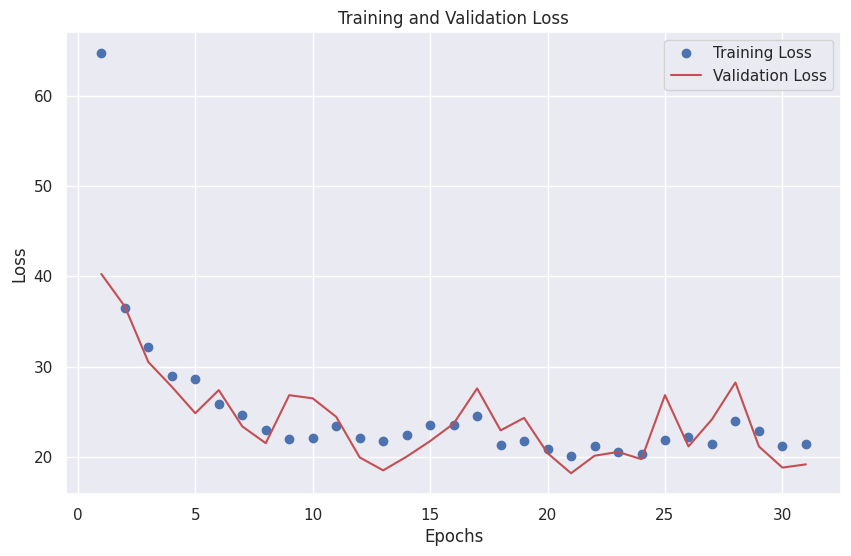

In [89]:
import matplotlib.pyplot as plt

# Extract training and validation loss from model_history
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()


##Model-2

In [90]:
l1 = ['Date', 'Month', 'Day', 'week', 'Max Temp (°C)', 'Min Temp (°C)',
       'Mean Temp (°C)', 'Heat Deg Days (°C)', 'Cool Deg Days (°C)',
       'Total Snow (cm)',
       'Total_rented_cycle']
df = df[l1]

In [91]:
#Forming the Input and Target dataset
y=df['Total_rented_cycle']
X = df.drop(columns=['Date','Total_rented_cycle'])
WINDOW_LENGTH_set = [7]
dropout_set = [0.01]
combination = list(product(WINDOW_LENGTH_set,dropout_set))

accuracy=[]
print("WINDOW_LENGTH_set,dropout_set,train_loss,val_loss,mape")
for comb in combination:
  window_size, dropout= comb[0],comb[1]
  print(window_size, dropout,"- - -")
  #Forming the batched data
  X_b, y_b = [], []
  for i in range(window_size-1, len(X)):
    dfx = X[i-window_size+1:i+1]
    dfy = y[i]
    X_b.append(X[i-window_size+1:i+1])
    y_b.append(y[i])
  X_b = np.array(X_b)
  y_b = np.array(y_b)
  #Spliting into train and test data set
  X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

  #Creating tensorflow training and validation Dataset object
  train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  train_data = train_data.cache().shuffle(100).batch(16).repeat()
  val_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
  val_data = val_data.batch(32).repeat()

  #Defining LSTM Model Architechture
  # dropout = 0.02
  lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(
            64, input_shape=X_train.shape[-2:], dropout=dropout),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dense(64),
        tf.keras.layers.Dense(1)
    ])
  #Early stopping criteria
  early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
  #Building the Model
  mape = tf.keras.losses.MeanAbsolutePercentageError()
  lstm_model.compile(optimizer='adam', loss=mape)

  # Training the model with early stopping callback
  model_history = lstm_model.fit(
      train_data,
      epochs=200,
      steps_per_epoch=500,
      validation_data=val_data,
      validation_steps=50,
      callbacks=[early_stopping]
  )
  #Predicting with trained Model
  yhat = lstm_model.predict(X_test).reshape(1, -1)[0]

  best_train_loss = min(model_history.history['loss'])
  best_val_loss = min(model_history.history['val_loss'])
  MAPE=cal_mape(y_test,yhat)

  print(f"Best training loss:{best_train_loss}, Best Validation loss:{best_val_loss}, MAPE on test set:{MAPE}")
  accuracy.append([window_size, dropout,best_train_loss,best_val_loss,MAPE])
accuracy_df = pd.DataFrame(accuracy,columns=["window_size", "dropout","best_train_loss","best_val_loss","MAPE"])
print("MAPE obtained from different hyperparameter:\n",accuracy_df)

WINDOW_LENGTH_set,dropout_set,train_loss,val_loss,mape
7 0.01 - - -
Epoch 1/200
500/500 [==============================] - 7s 8ms/step - loss: 73.5124 - val_loss: 60.5476
Epoch 2/200
500/500 [==============================] - 3s 6ms/step - loss: 48.5681 - val_loss: 34.9818
Epoch 3/200
500/500 [==============================] - 4s 8ms/step - loss: 30.4034 - val_loss: 33.8208
Epoch 4/200
500/500 [==============================] - 3s 7ms/step - loss: 26.7674 - val_loss: 34.0527
Epoch 5/200
500/500 [==============================] - 3s 7ms/step - loss: 24.6671 - val_loss: 33.8147
Epoch 6/200
500/500 [==============================] - 3s 7ms/step - loss: 21.8290 - val_loss: 34.3432
Epoch 7/200
500/500 [==============================] - 4s 9ms/step - loss: 19.2119 - val_loss: 34.9536
Epoch 8/200
500/500 [==============================] - 4s 7ms/step - loss: 17.6044 - val_loss: 35.5176
Epoch 9/200
500/500 [==============================] - 3s 7ms/step - loss: 16.5807 - val_loss: 36.4387
Epoch

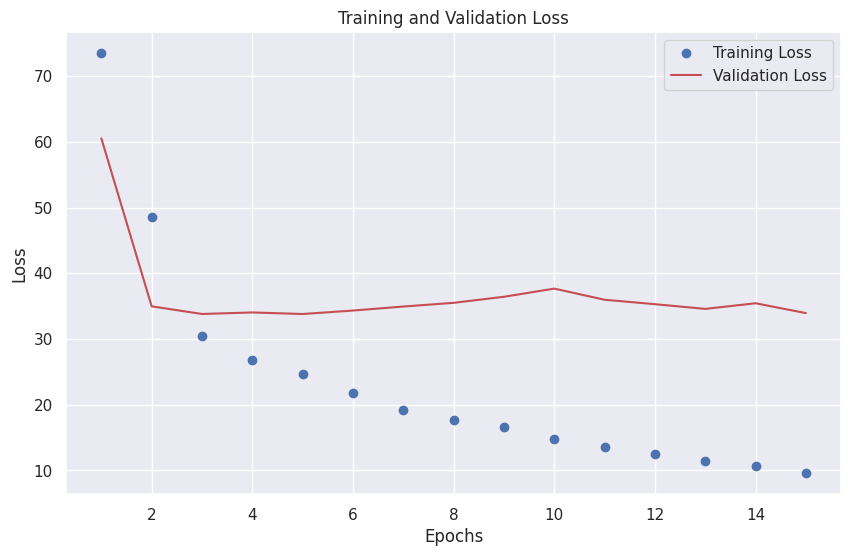

In [92]:
import matplotlib.pyplot as plt

# Extract training and validation loss from model_history
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()
